## Rap network analysis: Which rappers work together?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from collections import Counter

import networkx as nx
import re

In [2]:
networks = pd.read_csv(r'D:\Documents\DATA\Rap networks\rap_networks.csv', encoding='ISO-8859-1')

In [3]:
# Remove artists that are unnecessary, or that negatively impact the final graph
networks = networks[~networks.artist_name.isin(['El-P', 
                                                'Das Racist', 
                                                'Bhad Bhabie', 
                                                'YBN Nahmir',
                                                'YBN Cordae'
                                                'Bruno Mars', 
                                                'Justin Bieber',
                                                'Justin Timberlake',
                                                'Rihanna',
                                                'Ariana Grande',
                                                'Ciara',
                                                'Ne-Yo',
                                                'Miguel',
                                                'Joyner Lucas',
                                                'Lauryn Hill',
                                                'Crooked I',
                                                'OG Maco',
                                                'Blueface',
                                                'Cardi B',
                                                'Lil Wop',
                                                'City Morgue',
                                                'Problem',
                                                'Too $hort',
                                                'YNW Melly',
                                                'Lil Dicky',
                                                'Erick Arc Elliott',
                                                'Meyhem Lauren',
                                                'Roc Marciano',
                                                'BONES', 
                                                'Xavier Wulf', 
                                                'Chris Travis', 
                                                'Eddy Baker', 
                                                'Rozz Dyliams',
                                                'Flatbush Zombies'
                                               ])]


# Remove rappers without a certain number of songs
artist_counts = networks.artist_name.value_counts()
networks = networks[networks.artist_name.isin(artist_counts[artist_counts > 25].index)]

In [4]:
# Clean song names
networks.song_name = networks.song_name.apply(lambda x: str(x).lower())
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='â', repl=''))
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='ã©', repl='e'))
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='<u\\+200b>', repl=''))
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='\xa0', repl=' '))
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='\x92', repl="'"))
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='\x94', repl='"'))
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='\\$', repl='s'))

# Clean artist names
networks.artist_name = networks.artist_name.apply(lambda x: str(x).lower())
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='â', repl=''))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='ã©', repl='e'))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='<u\\+200b>', repl=''))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='\xa0', repl=' '))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='\x92', repl="'"))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='\x94', repl='"'))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='\\$', repl='s'))

# Replace specific artist names
networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='tyler, the creator', repl='tyler the creator'))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='tyler, the creator', repl='tyler the creator'))

networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='puff daddy', repl='diddy'))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='puff daddy', repl='diddy'))

networks.song_name = networks.song_name.apply(lambda x: re.sub(string=x, pattern='young jeezy', repl='jeezy'))
networks.artist_name = networks.artist_name.apply(lambda x: re.sub(string=x, pattern='young jeezy', repl='jeezy'))

In [5]:
# Add features
features = networks.song_name.str.extract(r'(ft..*)|(feat..*)')
networks['all_features'] = features.apply(lambda x: x[1] if pd.isnull(x[0]) else x[0], axis=1)

# Filter to only songs with features
networks = networks[~networks['all_features'].isnull()]

# Clean features
networks['all_features'] = networks['all_features'].apply(lambda x: re.sub(string=x, pattern='\\)', repl=''))
networks['all_features'] = networks['all_features'].apply(lambda x: re.sub(string=x, pattern='feat\\. ', repl=''))
networks['all_features'] = networks['all_features'].apply(lambda x: re.sub(string=x, pattern='ft\\. ', repl=''))

# # Convert to list of features
networks['list_features'] = networks['all_features'].apply(lambda x: re.split(string=x, pattern=' & |, '))

In [6]:
# Create list of artist-to-artist features
def feature_connections(artist_name, list_features):
    connections = []
    for feature in list_features:
        artist1 = artist_name
        artist2 = feature
        connection = tuple(sorted([artist1, artist2]))
        connections.append(connection)
    return(connections)

networks['list_connections'] = networks.apply(lambda x: feature_connections(x['artist_name'], x['list_features']), axis=1)

# List of all connections
connections_list = [connection for song in list(networks.list_connections) for connection in song]

# All connections with frequency counter
connections_dict = dict(Counter(connections_list))

# Only connections that have occurred at least X times
connections_dict = {connection: count for connection, count in connections_dict.items() if count>=1}

# Remove self-connections
connections_dict = {connection: count for connection, count in connections_dict.items() if connection[0] != connection[1]}

# Only connections where both connectees are in our initial dataframe artist list
connections_dict = {connection: count for connection, count in connections_dict.items() if (connection[0] in list(networks.artist_name)) & (connection[1] in list(networks.artist_name))}

In [7]:
# Create symmetric graph of connections
# Symmetric: no importance given to who the song is officially credited to
def create_symmetric_graph(connections_dict):
    g = nx.Graph()
    print('Adding connections...')
    for connection in connections_dict.keys():
        artist1 = connection[0]
        artist2 = connection[1]
        count = connections_dict[connection]
        g.add_edge(connection[0], connection[1], weight=count)    
    return(g)

# Plot symmetric graph of connections
def plot_symmetric_graph(graph, size):
    print('Drawing graph...')
    plt.figure(figsize=(size,size))
    nx.circular_layout(g)
    nx.draw_networkx(g,
                     node_size=16, 
                     font_size=16, 
                     alpha=0.5,
                     arrows=False, 
                     edge_color='gray', 
                     font_color='black',
                     style='solid',
                     linewidths=0.1)

Adding connections...
Drawing graph...


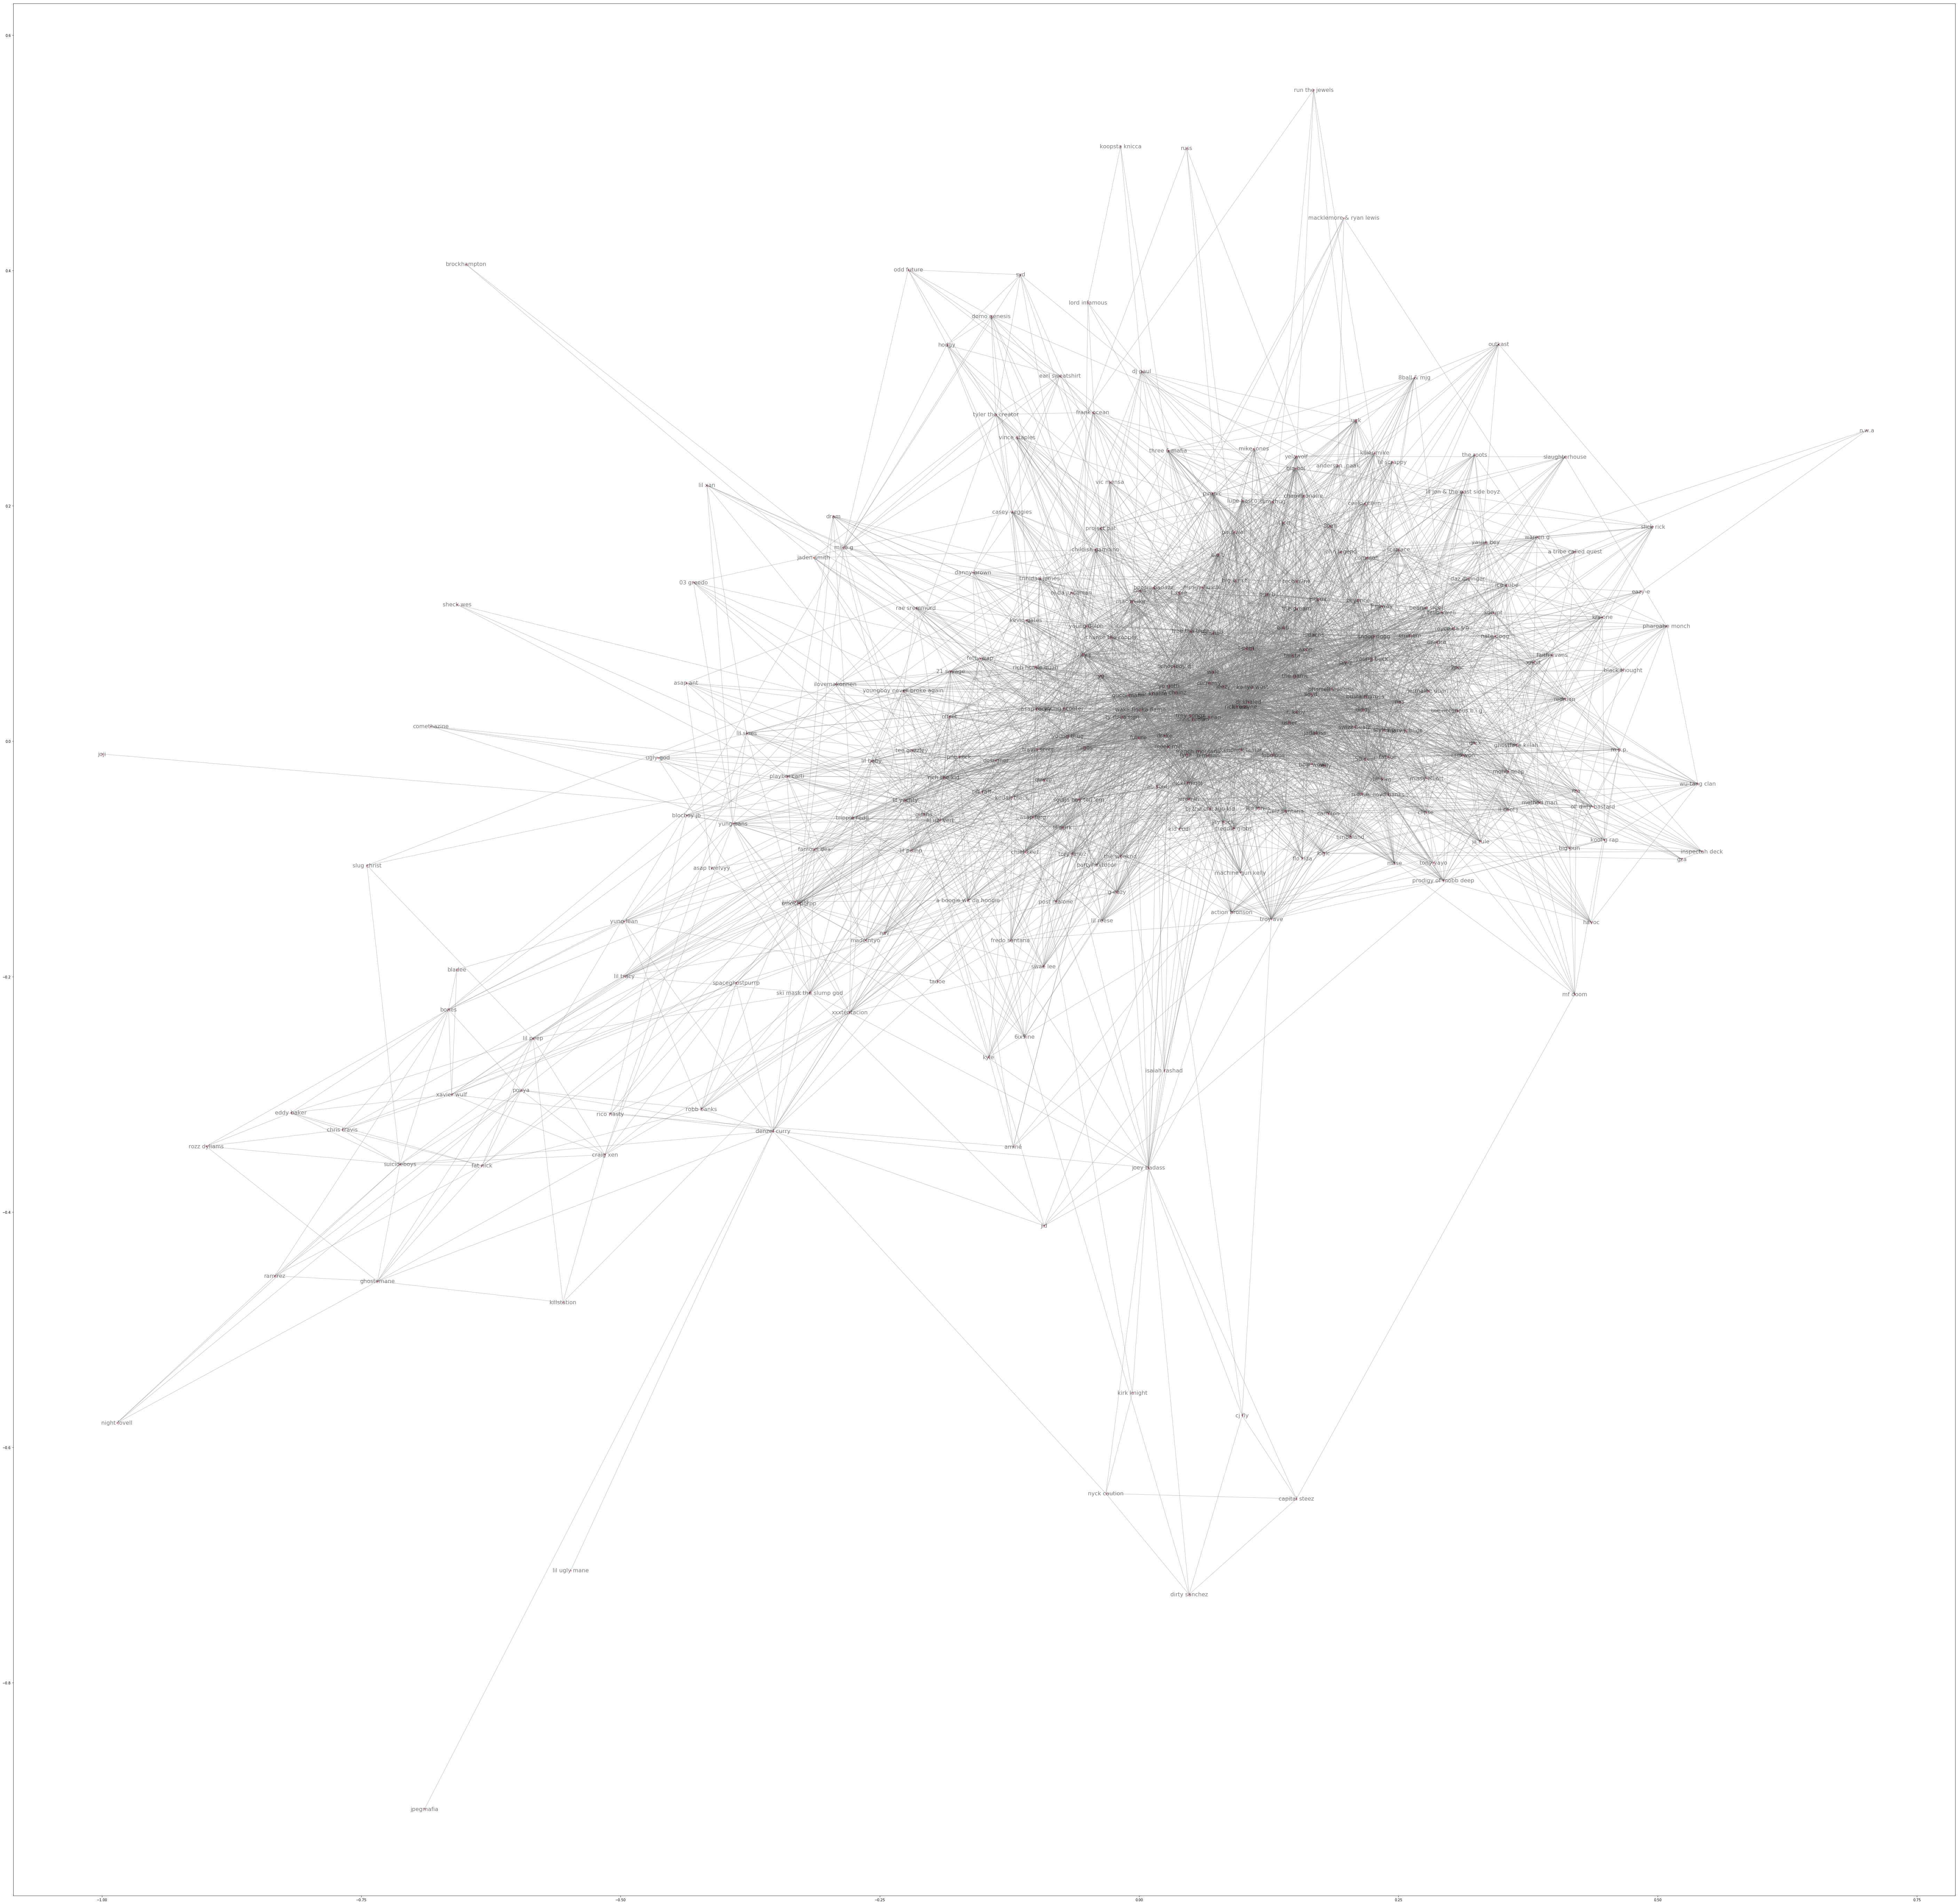

In [8]:
g = create_symmetric_graph(connections_dict)
plot_symmetric_graph(g, 100)